In [1]:
import numpy as np
import matplotlib.pyplot as plt
import library.volumes.strmesh as vol
import scipy.io as sio
from sklearn.pipeline import Pipeline
from sklearn.kernel_approximation import RBFSampler
from sklearn import mixture
import open3d as o3d

nolineal=1
xfilename='data/curvature/shrec16/'
gtfilename='data/gt/shrec16/'
model='wolf'
tipo='cuts'
shape='3'
components=2
montecarlo=200
gamma=1e-2
geotest=True

In [2]:
# filename=gtfilename+model+'-'+tipo+'-'+shape+'.mat'
# info=sio.whosmat(filename)[0]
# mat=sio.loadmat(filename)
# gt=mat[info[0]]-1
# tamgt=gt.shape[0]

In [3]:
filename=xfilename+tipo+'/'+tipo+'_'+model+'_shape_'+shape+'.mat'
info=sio.whosmat(filename)[0]
mat=sio.loadmat(filename)
X=mat[info[0]]

In [4]:
#Dir data
base='data/shrec2016/'+tipo+'/'
data=tipo+'_'+model+'_shape_'+shape+'.mat'
mesh1=vol.StrMesh(filename=base+data)

!Mesh load complete!
Vertices: 2096
Triangles: 4121


In [5]:
base='data/shrec2016/null/'
data=model+'.mat'
mesh2=vol.StrMesh(filename=base+data)

!Mesh load complete!
Vertices: 4344
Triangles: 8684


In [6]:
if nolineal==1:
    #gmm-no lineal
    steps = [('rff', RBFSampler(gamma=gamma,n_components=montecarlo,random_state=48)), 
            ('cluster', mixture.BayesianGaussianMixture(n_components=components, random_state=48))] #clasificador 
    method = Pipeline(steps)
else:
    #gmm lineal
    steps = [ ('cluster', mixture.BayesianGaussianMixture(n_components=components, random_state=48))] #clasificador 
    method = Pipeline(steps) 

In [7]:
method.fit(X)
Z=method.predict(X)

In [8]:
tam1=mesh1.vertices.shape[0]
tam2=mesh2.vertices.shape[0]
Z1=Z[0:tam1]
Z2=Z[tam1:]

In [10]:
norm=np.sqrt(mesh1.getArea())
print(norm)

82.76498453802101


In [ ]:
if geotest:
    import gdist
    vertices=mesh1.vertices.astype(np.float64)
    triangles = mesh1.triangles.astype(np.int32)
    geodist=np.array([])
    for i in range(tamgt):
        if not(np.isnan(gt[i])):
            print('Vertex number:',i)
            label=Z2[gt[i]]
            src=np.array([i],dtype=np.int32)
            print(src)
            trg=np.where(Z1==label)[0].astype(np.int32)
            dist=gdist.compute_gdist(vertices, triangles, source_indices=src, target_indices=trg)
            geodist=np.concatenate((geodist,dist.min(keepdims=True)))#dist.min(keepdims=True)
    geodist=geodist/norm

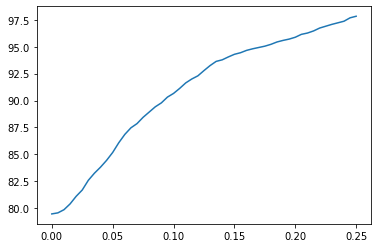

In [19]:
if geotest:
    step=0.005
    thresh = np.arange(0,0.25+step,step)
    curve=[]
    for i in range(thresh.shape[0]):
        curve.append(100*np.sum(geodist<=thresh[i])/geodist.shape[0])
    curve=np.array(curve)
    
    plt.plot(thresh,curve)
    plt.show()

In [20]:
if geotest:
    index=np.where(curve<=100)
    percentage=np.max(curve[index])
    ind=np.where(curve==percentage)[0]
    error=np.min(thresh[ind])
    print('Geodesic Error:',error)
    print('Percentage:',percentage)

Geodesic Error: 0.25
Percentage: 97.82979761033894


In [9]:
rmin=np.min(Z1)
rmax=np.max(Z1)
mesh1.assignHeatColor(minimum=rmin,maximum=rmax,value=Z1)
rmin=np.min(Z2)
rmax=np.max(Z2)
mesh2.assignHeatColor(minimum=rmin,maximum=rmax,value=Z2)

In [10]:
vis = o3d.visualization.Visualizer()
vis.create_window(window_name='TopLeft', width=960, height=540, left=0, top=400)
vis.add_geometry(mesh1.mesh)

vis2 = o3d.visualization.Visualizer()
vis2.create_window(window_name='TopRight', width=960, height=540, left=960, top=400)
vis2.add_geometry(mesh2.mesh)

while True:
    vis.update_geometry(mesh1.mesh)
    if not vis.poll_events():
        break
    vis.update_renderer()

    vis2.update_geometry(mesh2.mesh)
    if not vis2.poll_events():
        break
    vis2.update_renderer()

vis.destroy_window()
vis2.destroy_window()